## Pretraining LLMs

![alt text](dataset_prev.jpg)
Dataset from: https://www.kaggle.com/datasets/chaitanyakck/medical-text

####  Setup and Imports

In [8]:

import torch
import tiktoken
from matplotlib import pyplot as plt
from custom_llm_model import GPTModel, create_dataloader_v1, calc_loss_batch, generate_text_simple

def visualize_attention(attention_weights):
    plt.figure(figsize=(10, 8))
    plt.imshow(attention_weights, cmap='viridis')
    plt.colorbar()
    plt.title("Attention Weights")
    plt.show()

from importlib.metadata import version
pkgs = ["matplotlib", "numpy", "tiktoken", "torch"]
for p in pkgs:
    print(f"{p} version: {version(p)}")


matplotlib version: 3.8.2
numpy version: 1.26.4
tiktoken version: 0.7.0
torch version: 2.2.1+cu121


#### Model Configuration

In [9]:
GPT_CONFIG = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "num_token_types": 2  
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

#### Text Generation

In [10]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


#### Preparing the Dataset

In [12]:
with open("medicaltext.txt", "r", encoding="utf-8") as file:
    text_data = file.read()


print(text_data[:99])
print(text_data[-99:])

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)


train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)


print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
    break

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)
    break


train_tokens = sum(batch[0].numel() for batch in train_loader)
val_tokens = sum(batch[0].numel() for batch in val_loader)

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

4	Catheterization laboratory events and hospital outcome with direct angioplasty for acute myocardi
 there may be a relationship between heparin withdrawal and cerebral infarction in some patients. 



Characters: 17811683
Tokens: 3880805
Train loader:
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
Training tokens: 3492864
Validation tokens: 387840
All tokens: 3880704


#### Initial Loss Calculation

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    num_batches = num_batches or len(data_loader)
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        loss = calc_loss_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()
    return total_loss / num_batches

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.995232704272196
Validation loss: 10.995182970897503


#### Training the Model

In [14]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
                val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        model.eval()
        with torch.no_grad():
            sample_ids = generate_text_simple(
                model,
                text_to_token_ids(start_context, tokenizer).to(device),
                max_new_tokens=50,
                context_size=GPT_CONFIG["context_length"]
            )
        print("Generated text:", token_ids_to_text(sample_ids, tokenizer))
        model.train()

    return train_losses, val_losses, track_tokens_seen

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 2 #10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

torch.save(model.state_dict(), "medicalLLM.pth")

Ep 1 (Step 000000): Train loss 10.410, Val loss 10.386
Ep 1 (Step 000005): Train loss 9.202, Val loss 9.181
Ep 1 (Step 000010): Train loss 8.475, Val loss 8.481
Ep 1 (Step 000015): Train loss 8.071, Val loss 8.223
Ep 1 (Step 000020): Train loss 8.064, Val loss 8.196
Ep 1 (Step 000025): Train loss 7.909, Val loss 8.090
Ep 1 (Step 000030): Train loss 7.859, Val loss 8.004
Ep 1 (Step 000035): Train loss 7.829, Val loss 7.907
Ep 1 (Step 000040): Train loss 7.624, Val loss 7.868
Ep 1 (Step 000045): Train loss 7.692, Val loss 7.796
Ep 1 (Step 000050): Train loss 7.727, Val loss 7.763
Ep 1 (Step 000055): Train loss 7.374, Val loss 7.736
Ep 1 (Step 000060): Train loss 7.503, Val loss 7.688
Ep 1 (Step 000065): Train loss 7.519, Val loss 7.625
Ep 1 (Step 000070): Train loss 7.321, Val loss 7.585
Ep 1 (Step 000075): Train loss 7.269, Val loss 7.563
Ep 1 (Step 000080): Train loss 7.368, Val loss 7.515
Ep 1 (Step 000085): Train loss 7.454, Val loss 7.479
Ep 1 (Step 000090): Train loss 7.102, Val lo

#### Visualizing Training Progress

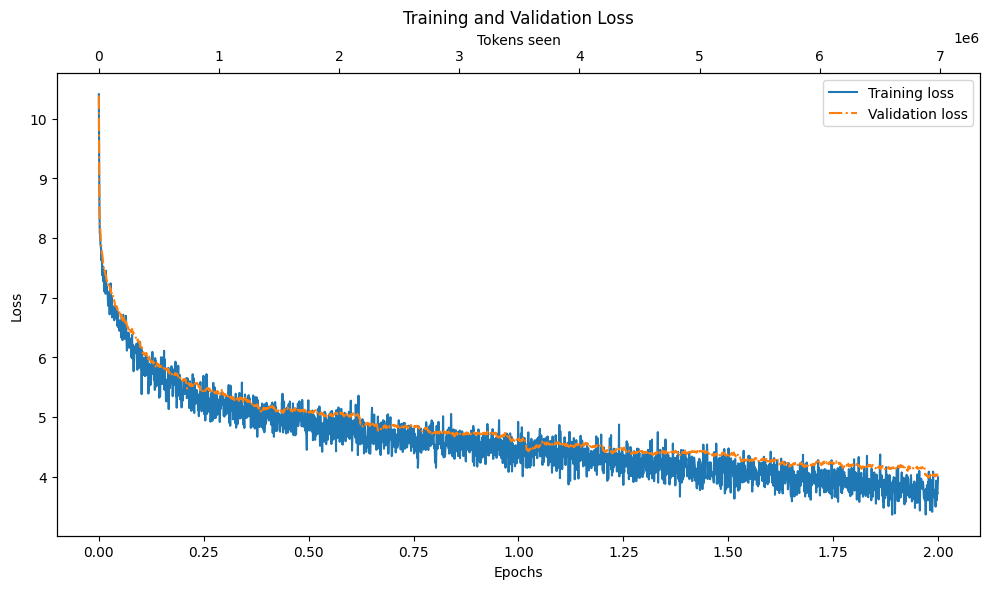

In [15]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")

    plt.title("Training and Validation Loss")
    plt.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#### Generating Text with Trained Model

In [17]:
model.eval()
start_context = "The jury listened intently as"

with torch.no_grad():
    token_ids = generate_text_simple(
        model=model,
        idx=text_to_token_ids(start_context, tokenizer).to(device),
        max_new_tokens=20,
        context_size=GPT_CONFIG["context_length"]
    )

print("Generated text:\n", token_ids_to_text(token_ids, tokenizer))

Generated text:
 The jury listened intently as a result of a significant increase in the incidence of the incidence of the disease. 
5	
